# Ungraded Lab: CelebA GAN Experiments

## Disable Warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Imports

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

import os
import zipfile
import glob
import urllib.request
from enum import Enum
from tqdm import tqdm
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from IPython.display import display
from IPython.display import Image as IpyImage
import imageio
import cv2

E0000 00:00:1722426277.911214      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0731 11:44:37.919718864      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0731 11:44:37.919734710      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0731 11:44:37.919738338      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0731 11:44:37.919741151      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0731 11:44:37.919743845      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

## Setup TPU

In [3]:
try:
  tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  print(f'Running on a TPU w/{tpu_cluster_resolver.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please make sure you have successfully chosen TPU runtime from the Edit/Notebook settings menu')

strategy = tf.distribute.TPUStrategy(tpu_cluster_resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1722426305.125293      13 service.cc:145] XLA service 0x5952157fc200 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722426305.125357      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1722426305.125362      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1722426305.125365      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1722426305.125368      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1722426305.125373      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1722426305.125376      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1722426305.125378      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1722426305.125381      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
Running on a TPU w/8 cores
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/repli

In [4]:
class Reduction(Enum):
    NONE = 0
    SUM = 1
    MEAN = 2
    CONCAT = 3

def distributed(*reduction_flags):
    def _decorator(fun):
        def per_replica_reduction(z, flag):
            if flag == Reduction.NONE:
                return z
            elif flag == Reduction.SUM:
                return strategy.reduce(tf.distribute.ReduceOp.SUM, z, axis=None)
            elif flag == Reduction.MEAN:
                return strategy.reduce(tf.distribute.ReduceOp.MEAN, z, axis=None)
            elif flag == Reduction.CONCAT:
                z_list = strategy.experimental_local_results(z)
                return tf.concat(z_list, axis=0)
            else:
                raise NotImplementedError()

        @tf.function
        def _decorated_fun(*args, **kwargs):
            fun_result = strategy.run(fun, args=args, kwargs=kwargs)
            if len(reduction_flags) == 0:
                assert fun_result is None
                return
            elif len(reduction_flags) == 1:
                assert type(fun_result) is not tuple and fun_redult is not None
                return per_replica_reduction(fun_result, *reduction_flags)
            else:
                assert type(fun_result) is tuple
                return tuple((per_replica_reduction(fr, rf) for fr, rf in zip(fun_result, reduction_flags)))
        return _decorated_fun
    return _decorator

## Download and Prepare the Dataset

In [5]:
# make a data directory
try:
  os.mkdir('/tmp/celeb')
except OSError:
  pass

# download the dataset archive
data_url = "https://storage.googleapis.com/learning-datasets/Resources/archive.zip"
data_file_name = "archive.zip"
download_dir = '/tmp/celeb/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zipped file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [6]:
def load_celeba(batch_size, resize=64, crop_size=128):
  """Creates batches of preprocessed images from the JPG files
  Args:
    batch_size - batch size
    resize - size in pixels to resize the images
    crop_size - size to crop from the image

  Returns:
    prepared dataset
  """
  # initialize zero-filled array equal to the size of the dataset
  image_paths = sorted(glob.glob("/tmp/celeb/img_align_celeba/img_align_celeba/*.jpg"))
  images = np.zeros((len(image_paths), resize, resize, 3), np.uint8)
  print("Creating Images")

  # crop and resize the raw images then put into the array
  for i, path in tqdm(enumerate(image_paths)):
    with Image.open(path) as img:
      left = (img.size[0] - crop_size) // 2
      top = (img.size[1] - crop_size) // 2
      right = left + crop_size
      bottom = top + crop_size
      img = img.crop((left, top, right, bottom))
      img = img.resize((resize, resize), Image.LANCZOS)
      images[i] = np.asarray(img, np.uint8)

  # split the images array into two
  split_n = images.shape[0] // 2
  images1, images2 = images[:split_n], images[split_n:2 * split_n]
  del images

  # preprocessing function to convert the pixel values into the range [-1,1]
  def preprocess(img):
      x = tf.cast(img, tf.float32) / 127.5 - 1.0
      return x

  # use the preprocessing function on the arrays and create batches
  dataset = tf.data.Dataset.from_tensor_slices((images1, images2))
  dataset = dataset.map(
      lambda x1, x2: (preprocess(x1), preprocess(x2))
  ).shuffle(4096).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

# use the function above to load and prepare the dataset
batch_size = 8
batch_size = batch_size * strategy.num_replicas_in_sync
dataset = load_celeba(batch_size)
out_dir = "celeba_out"

Creating Images


202599it [02:52, 1173.37it/s]


## Build the Model

In [7]:
# Utilities

def _get_norm_layer(norm):
    if norm == 'NA':
        return lambda: lambda x: x
    elif norm == 'batch_normalization':
        return layers.BatchNormalization
    elif norm == 'layer_normalization':
        return layers.LayerNormalization

In [8]:
def get_initializers():
    return (tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), # conv initializer
            tf.keras.initializers.RandomNormal(mean=1.0, stddev=0.02)) # bn gamma initializer

In [9]:
def gradient_penalty(f, real, fake, mode):
    def _gradient_penalty(f, real, fake=None):
        def _interpolate(a, b=None):
            if b is None:   # interpolation in DRAGAN
                beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter

        x = _interpolate(real, fake)
        with tf.GradientTape() as t:
            t.watch(x)
            pred = f(x)
        grad = t.gradient(pred, x)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)

        return gp

    if mode == 'none':
        gp = tf.constant(0, dtype=real.dtype)
    elif mode == 'dragan':
        gp = _gradient_penalty(f, real)
    elif mode == 'wgan-gp':
        gp = _gradient_penalty(f, real, fake)

    return gp

### Generator

In [10]:
def create_generator(input_shape=(1, 1, 128),
                    output_channels=3,
                    dim=64,
                    n_upsamplings=4,
                    norm='batch_normalization',
                    name='generator'):

    Normalization = _get_norm_layer(norm)
    conv_initializer, bn_gamma_initializer = get_initializers()

    # 0
    x = inputs = tf.keras.Input(shape=input_shape)

    # 1: 1x1 -> 4x4
    dimensions = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    x = layers.Conv2DTranspose(
        dimensions, 4, strides=1, padding='valid', use_bias=False,
        # kernel_initializer=conv_initializer
    )(x)
    x = Normalization(
        # gamma_initializer=bn_gamma_initializer
        )(x)
    x = layers.ReLU()(x)

    # 2: upsamplings, 4x4 -> 8x8 -> 16x16 -> ...
    for i in range(n_upsamplings - 1):
        dimensions = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        x = layers.Conv2DTranspose(
            dimensions, 4, strides=2, padding='same', use_bias=False,
            # kernel_initializer=conv_initializer
            )(x)
        x = Normalization(
            # gamma_initializer=bn_gamma_initializer
            )(x)
        x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(
        output_channels, 4, strides=2, padding='same',
        # kernel_initializer=conv_initializer
    )(x)

    outputs = layers.Activation('tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

### Discriminator

In [11]:
def create_discriminator(input_shape=(64, 64, 3),
                        dim=64,
                        n_downsamplings=4,
                        norm='batch_normalization',
                        name='discriminator'):
    Normalization = _get_norm_layer(norm)
    conv_initializer, bn_gamma_initializer = get_initializers()

    # 0
    x = inputs = tf.keras.Input(shape=input_shape)

    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    x = layers.Conv2D(dim, 4, strides=2, padding='same',
                      # kernel_initializer=conv_initializer
                      )(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    for i in range(n_downsamplings - 1):
        dimensions = min(dim * 2 ** (i + 1), dim * 8)
        x = layers.Conv2D(dimensions, 4, strides=2, padding='same', use_bias=False,
                          # kernel_initializer=conv_initializer
                          )(x)
        x = Normalization(
            # gamma_initializer=bn_gamma_initializer
            )(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

    # 2: logit
    outputs = layers.Conv2D(1, 4, strides=1, padding='valid',
                            # kernel_initializer=conv_initializer
                            )(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [12]:
# Settings
resize = 64
shape = (resize, resize, 3)
z_dim = 128
n_G_upsamplings = n_D_downsamplings = 4
gradient_penalty_mode = 'none'

if gradient_penalty_mode == 'none':
  d_norm = 'batch_normalization'
elif gradient_penalty_mode in ['dragan', 'wgan-gp']:
  # Avoid using BN with GP
  d_norm = 'layer_normalization'
gradient_penalty_weight = 10.0

In [13]:
# Build the GAN
with strategy.scope():
    # create the generator model
    model_G = create_generator(input_shape=(1, 1, z_dim), output_channels=shape[-1], n_upsamplings=n_G_upsamplings)

    # create the discriminator model
    model_D = create_discriminator(input_shape=shape, n_downsamplings=n_D_downsamplings, norm=d_norm)

    # print summaries
    model_G.summary()
    model_D.summary()

    # set optimizers
    param_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    param_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    # create distributed dataset
    dataset = strategy.experimental_distribute_dataset(dataset)

    # set the loss function
    loss_func = tf.keras.losses.BinaryCrossentropy(
        from_logits=True,
        reduction=tf.keras.losses.Reduction.NONE
    )

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │     1,048,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,808,003 (14.53 MB)

 Trainable params: 3,806,083 (14.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 1)        │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,425 (10.56 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

I0000 00:00:1722426609.623186      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## Training

In [14]:
# Utilities

def make_grid(imgs, nrow, padding=0):
    assert imgs.ndim == 4 and nrow > 0

    batch, height, width, ch = imgs.shape
    n = nrow * (batch // nrow + np.sign(batch % nrow))
    ncol = n // nrow
    pad = np.zeros((n - batch, height, width, ch), imgs.dtype)
    x = np.concatenate([imgs, pad], axis=0)

    # border padding if required
    if padding > 0:
        x = np.pad(x, ((0, 0), (0, padding), (0, padding), (0, 0)),
                   "constant", constant_values=(0, 0))
        height += padding
        width += padding

    x = x.reshape(ncol, nrow, height, width, ch)
    x = x.transpose([0, 2, 1, 3, 4])  # (ncol, height, nrow, width, ch)
    x = x.reshape(height * ncol, width * nrow, ch)

    if padding > 0:
        x = x[:(height * ncol - padding),:(width * nrow - padding),:]
    return x

In [15]:
def save_img(imgs, filepath, nrow, padding=0):
    grid_img = make_grid(imgs, nrow, padding=padding)
    grid_img = ((grid_img + 1.0) * 127.5).astype(np.uint8)
    with Image.fromarray(grid_img) as img:
        img.save(filepath)

In [16]:
@distributed(Reduction.SUM, Reduction.SUM, Reduction.CONCAT)
def train_on_batch(real_img1, real_img2):
    '''trains the GAN on a given batch'''
    # concatenate the real image inputs
    real_img = tf.concat([real_img1, real_img2], axis=0)

    # PHASE ONE - train the discriminator
    with tf.GradientTape() as d_tape:

        # create noise input
        z = tf.random.normal(shape=(real_img.shape[0], 1, 1, z_dim))

        # generate fake images
        fake_img = model_G(z)

        # feed the fake images to the discriminator
        fake_out = model_D(fake_img)

        # feed the real images to the discriminator
        real_out = model_D(real_img)

        # use the loss function to measure how well the discriminator
        # labels fake or real images
        d_fake_loss = loss_func(tf.zeros_like(fake_out), fake_out)
        d_real_loss = loss_func(tf.ones_like(real_out), real_out)

        # get the total loss
        d_loss = (d_fake_loss + d_real_loss)
        d_loss = tf.reduce_sum(d_loss) / (batch_size * 2)

        # Gradient Penalty (ignore if you set mode to `none`)
        gp = gradient_penalty(partial(model_D, training=True), real_img, fake_img, mode=gradient_penalty_mode)
        gp = gp  / (batch_size * 2)
        d_loss = d_loss + gp * gradient_penalty_weight

    # get the gradients
    gradients = d_tape.gradient(d_loss, model_D.trainable_variables)

    # update the weights of the discriminator
    param_D.apply_gradients(zip(gradients, model_D.trainable_variables))


    # PHASE TWO - train the generator
    with tf.GradientTape() as g_tape:
        # create noise input
        z = tf.random.normal(shape=(real_img.shape[0], 1, 1, z_dim))

        # generate fake images
        fake_img = model_G(z)

        # feed fake images to the discriminator
        fake_out = model_D(fake_img)

        # use loss function to measure how well the generator
        # is able to trick the discriminator (i.e. model_D should output 1's)
        g_loss = loss_func(tf.ones_like(fake_out), fake_out)
        g_loss = tf.reduce_sum(g_loss) / (batch_size * 2)

    # get the gradients
    gradients = g_tape.gradient(g_loss, model_G.trainable_variables)

    # update the weights of the generator
    param_G.apply_gradients(zip(gradients, model_G.trainable_variables))

    # return the losses and fake images for monitoring
    return d_loss, g_loss, fake_img

[Epoch 0]: : 0it [00:00, ?it/s]2024-07-31 11:50:26.313566: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node adam/AssignAddVariableOp.
I0000 00:00:1722426626.599043     804 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(588233b1c2d542af:0:0), session_name()
I0000 00:00:1722426630.546045     804 tpu_compile_op_common.cc:245] Compilation of 588233b1c2d542af:0:0 with session name  took 3.946960777s and succeeded
I0000 00:00:1722426630.558612     804 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(588233b1c2d542af:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster__decorated_fun_8384464304420930506", property.function_library_fingerprint = 16051476627665726822, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, 

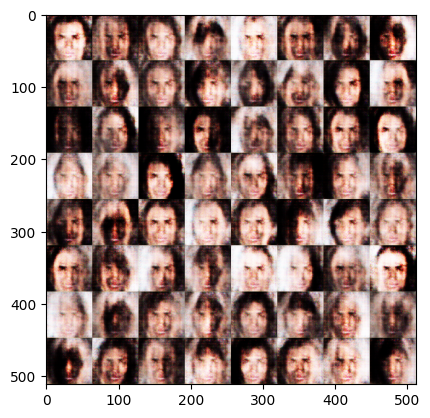

[Epoch 1]: : 1582it [00:29, 53.05it/s, g_loss=0.469, d_loss=0.213]


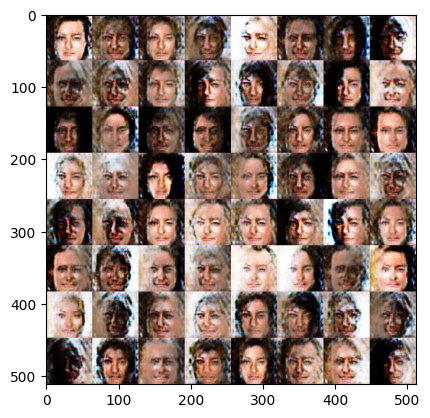

[Epoch 2]: : 1582it [00:29, 52.89it/s, g_loss=0.175, d_loss=0.114]  


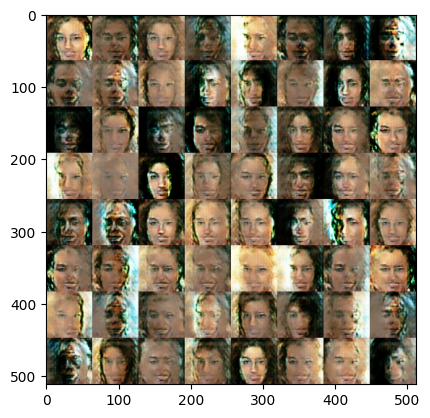

[Epoch 3]: : 1582it [00:29, 53.13it/s, g_loss=0.221, d_loss=0.264]  


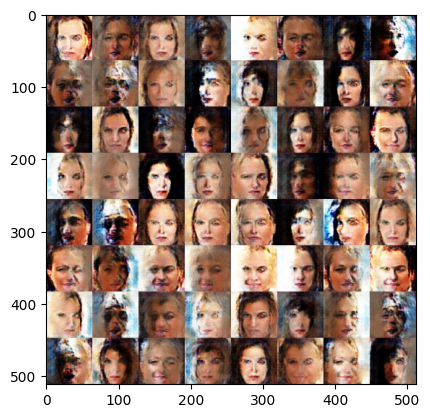

[Epoch 4]: : 1582it [00:29, 52.89it/s, g_loss=0.0646, d_loss=0.108] 


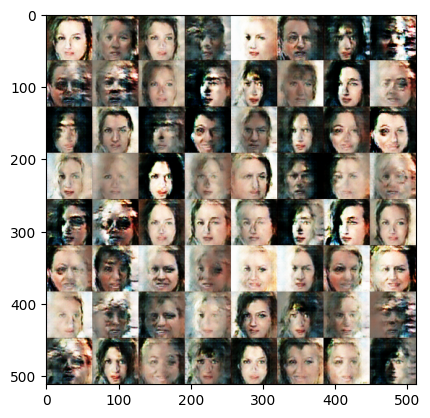

[Epoch 5]: : 1582it [00:29, 52.97it/s, g_loss=0.0645, d_loss=0.0978]


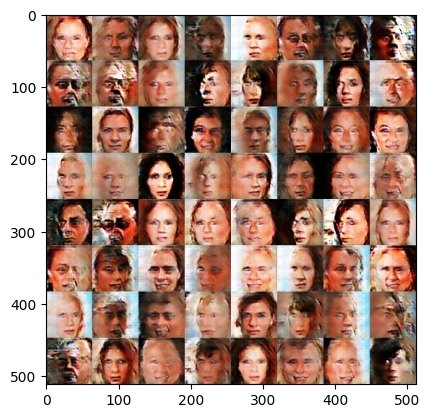

[Epoch 6]: : 1582it [00:29, 53.40it/s, g_loss=0.0997, d_loss=0.157] 


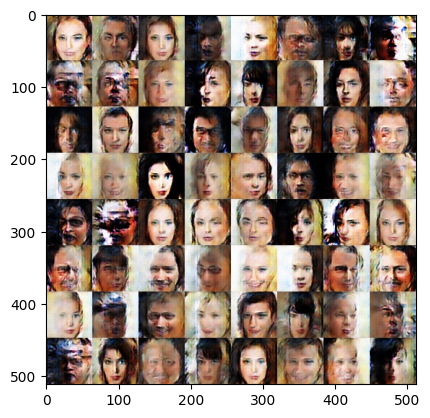

[Epoch 7]: : 1582it [00:29, 53.22it/s, g_loss=0.0848, d_loss=0.108] 


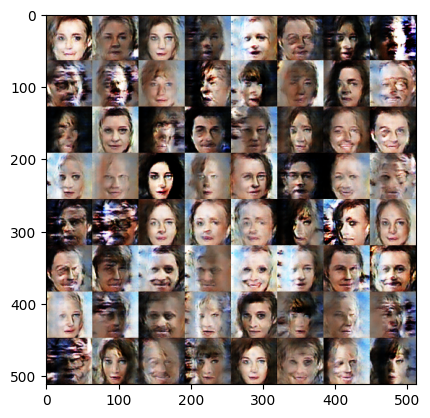

[Epoch 8]: : 1582it [00:29, 53.07it/s, g_loss=0.0238, d_loss=0.0937]


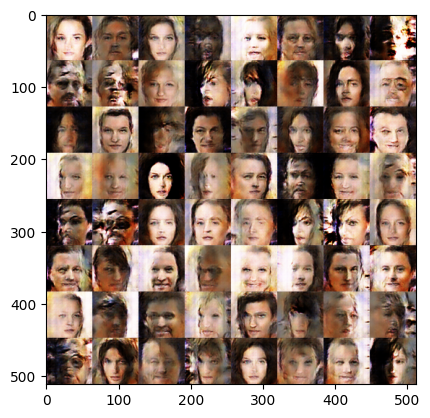

[Epoch 9]: : 1582it [00:29, 53.37it/s, g_loss=0.0828, d_loss=0.0961] 


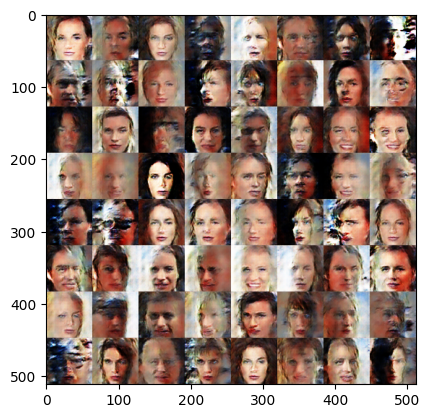

[Epoch 10]: : 1582it [00:29, 52.84it/s, g_loss=0.0335, d_loss=0.0498]


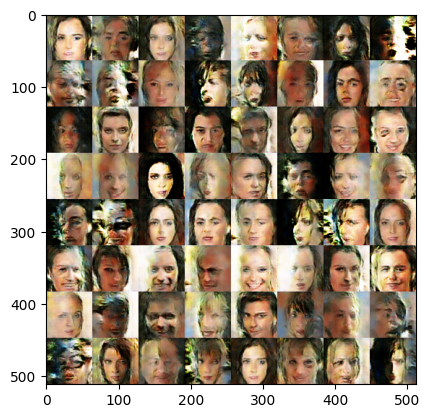

[Epoch 11]: : 1582it [00:29, 53.78it/s, g_loss=0.0473, d_loss=0.0773] 


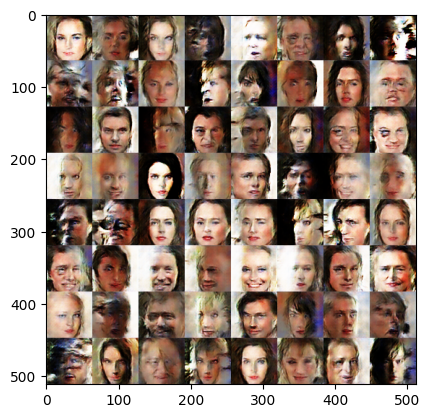

[Epoch 12]: : 1582it [00:29, 53.03it/s, g_loss=0.0332, d_loss=0.0335] 


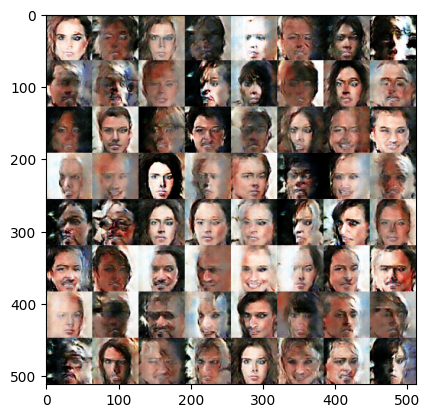

[Epoch 13]: : 1582it [00:29, 52.88it/s, g_loss=0.0155, d_loss=0.0574] 


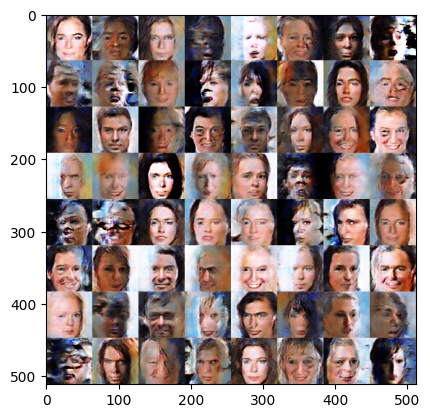

[Epoch 14]: : 1582it [00:29, 53.27it/s, g_loss=0.0322, d_loss=0.0966] 


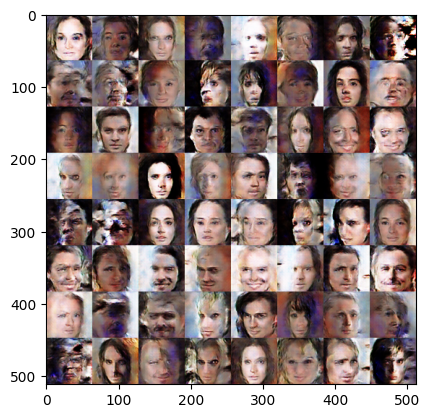

[Epoch 15]: : 1582it [00:29, 53.28it/s, g_loss=0.0445, d_loss=0.0802] 


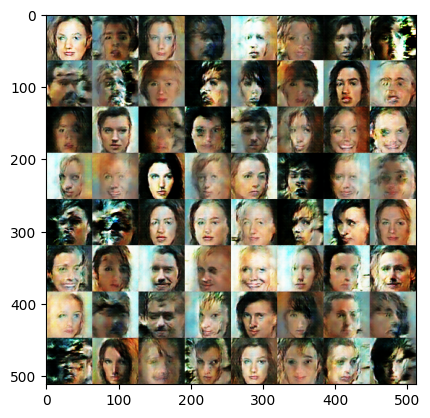

[Epoch 16]: : 1582it [00:29, 53.48it/s, g_loss=0.0151, d_loss=0.0318] 


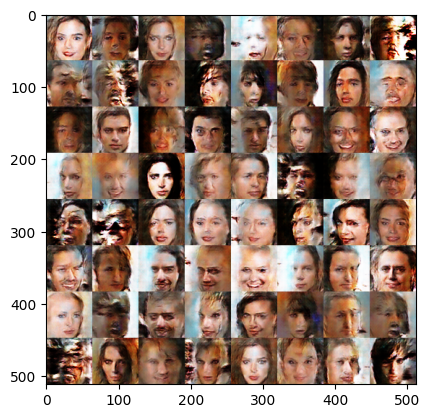

[Epoch 17]: : 1582it [00:29, 53.28it/s, g_loss=0.0271, d_loss=0.0156] 


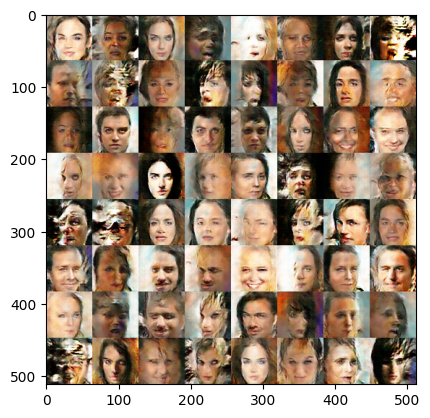

[Epoch 18]: : 1582it [00:29, 53.18it/s, g_loss=0.0155, d_loss=0.0804]  


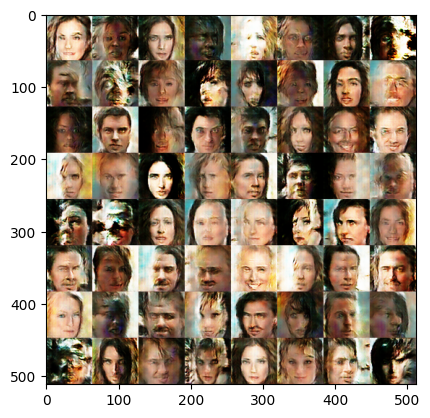

[Epoch 19]: : 1582it [00:29, 53.10it/s, g_loss=0.0199, d_loss=0.0572] 


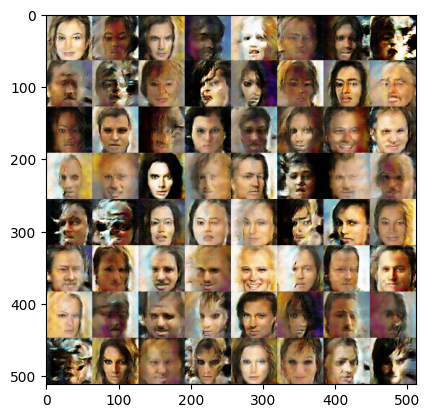

[Epoch 20]: : 866it [00:17, 56.01it/s, g_loss=0.0178, d_loss=0.0281]  

In [ ]:
# generate a batch of noisy input
test_z = tf.random.normal(shape=(64, 1, 1, z_dim))

# start loop
for epoch in range(30):
    with tqdm(dataset) as pbar:
        pbar.set_description(f"[Epoch {epoch}]")
        for step, (X1, X2) in enumerate(pbar):
            # train on the current batch
            d_loss, g_loss, fake = train_on_batch(X1, X2)

            # display the losses
            pbar.set_postfix({"g_loss": g_loss.numpy(), "d_loss": d_loss.numpy()})

        # generate fake images
        fake_img = model_G(test_z)

    # save output
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    file_path = out_dir+f"/epoch_{epoch:04}.png"
    save_img(fake_img.numpy()[:64], file_path, 8)

    # display gallery of fake faces
    if epoch % 1 == 0:
        with Image.open(file_path) as img:
            plt.imshow(np.asarray(img))
            plt.show()

## Display GIF sample results

In [ ]:
imgs = os.listdir('celeba_out')
imgs.sort()
imgs = [cv2.imread('celeba_out/' + i) for i in imgs]
imgs = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in imgs]
imageio.mimsave('anim.gif', imgs, fps=2)

In [ ]:
path="anim.gif"

with open(path,'rb') as f:
    display(IpyImage(data=f.read(), format='png'))